In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import seaborn as sns

In [2]:
plt.style.use('../style/style-formal.mplstyle')

In [3]:
def create_FL_dataframe(score_file, N=range(1, 11), score_booster:dict=None):
    """
    score_booster: (bug_name, run_idx) -> boost_multiplier
    """
    def _confidence(scores: list) -> float:
        return max(scores)

    def _assign_rank(autofl_scores, score_key="score"):
        # bug_name -> method -> score
        autofl_scores_rank = deepcopy(autofl_scores)
        sort_keys = [] # (-score, -aux, index) 
        for i, method in enumerate(autofl_scores_rank):
            score = autofl_scores_rank[method][score_key]
            sort_key = [-score]
            aux_score = autofl_scores_rank[method]["aux_score"]
            if isinstance(aux_score, tuple) or isinstance(aux_score, list):
                sort_key += list([-s for s in aux_score])
            elif isinstance(aux_score, float) or isinstance(aux_score, int):
                sort_key.append(-aux_score)
            else:
                raise Exception(f"Unsupported aux score type: {aux_score}")
            sort_key += [i, method]
            sort_keys.append(tuple(sort_key))
        for r, sort_item in enumerate(sorted(sort_keys)):
            method = sort_item[-1]
            autofl_scores_rank[method]["rank"] = r + 1
        return autofl_scores_rank

    with open(score_file, 'r') as f:
        data = json.load(f)

    rows = []
    predictions = data["predictions"]
    for bug_name in predictions:
        preds = predictions[bug_name]

        score_key = "score"
        if score_booster is not None:
            boosted_scores = []
            for method in preds:
                boost_multiplier = 1
                for matching_run_file in preds[method]["exprs"]:
                    run_idx = os.path.basename(
                        os.path.dirname(os.path.dirname(matching_run_file)))
                    if (bug_name, run_idx) in score_booster:
                        boost_multiplier *= score_booster[(bug_name, run_idx)]
                boosted_score = min(preds[method]["score"] * boost_multiplier, 1)
                preds[method][f"score_boosted"] = boosted_score
                boosted_scores.append(boosted_score)
            score_key = "score_boosted"
        
        scores = [preds[method][score_key] for method in preds]
        assert all([s <= 1. for s in scores])
        confidence_value = _confidence(scores)
        method_ranks = _assign_rank(preds, score_key=score_key)

        buggy_methods = data["buggy_methods"][bug_name]
        autofl_ranks = [method_ranks[m]["rank"] for m in buggy_methods]
        if len(autofl_ranks) == 0:
            continue
        AP = np.mean([(i+1)/r for i, r in enumerate(sorted(autofl_ranks))])
        if AP > 1:
            print(autofl_ranks)
            print(AP)
        rows.append([bug_name, confidence_value] \
                    + [1 in autofl_ranks, 1/min(autofl_ranks), AP])

    df = pd.DataFrame(
        data=rows,
        columns=["bug_name", "confidence"] \
            + ["P@1", "RR", "AP"])
    return df

def spearmanr_corr_with_confidence(df):
    from scipy.stats import spearmanr
    metrics = ["P@1", "RR", "AP"]
    corr_df = pd.DataFrame(data=[
        (m, corr.statistic, corr.pvalue)
        for m in metrics
        if (corr := spearmanr(df["confidence"], df[m]))
    ], columns=["metric", "spearman correlation coefficient", "p-value"])
    return corr_df

def draw_PR_curve(dfs, showF1=True, savepath=None, figsize=(7,3), title="Precision-Recall Curve for Precision@1 Prediction"):
    from sklearn.metrics import precision_recall_curve, auc
    if not isinstance(dfs, dict):
        dfs = {"original": dfs}
    plt.figure(figsize=figsize)
    markers = ['o', 'v', '^', '<', '>', '8', 's']
    for i, name in enumerate(dfs):
        df = dfs[name]
        precision, recall, thresholds = precision_recall_curve(df["P@1"], df["confidence"])
        f1 = 2 * (precision * recall) / (precision + recall)
        best_f1_idx = f1.argmax()
        auc_value = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC={auc_value:.3f})")
        if showF1:
            plt.scatter(recall[best_f1_idx], precision[best_f1_idx], zorder=100,
                        label=f"best f1={f1[best_f1_idx]:.2f} (thresh.={thresholds[best_f1_idx]:.2f})",
                        marker=markers[i])

    if title is not None:
        plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

# Use Test Score and APR Score to Refine FL Scores

,metric,spearman correlation coefficient,p-value
0,P@1,0.62,0.0
1,RR,0.71,0.0
2,AP,0.73,0.0


,metric,spearman correlation coefficient,p-value
0,P@1,0.60,0.0
1,RR,0.70,0.0
2,AP,0.72,0.0


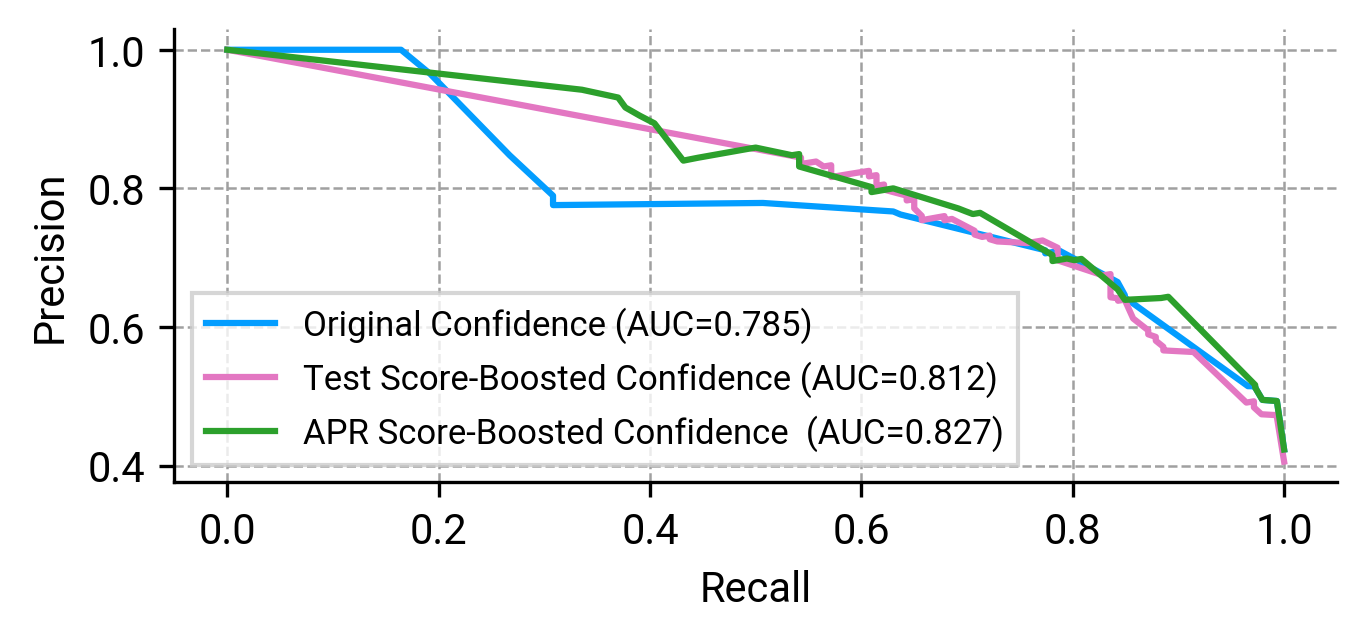

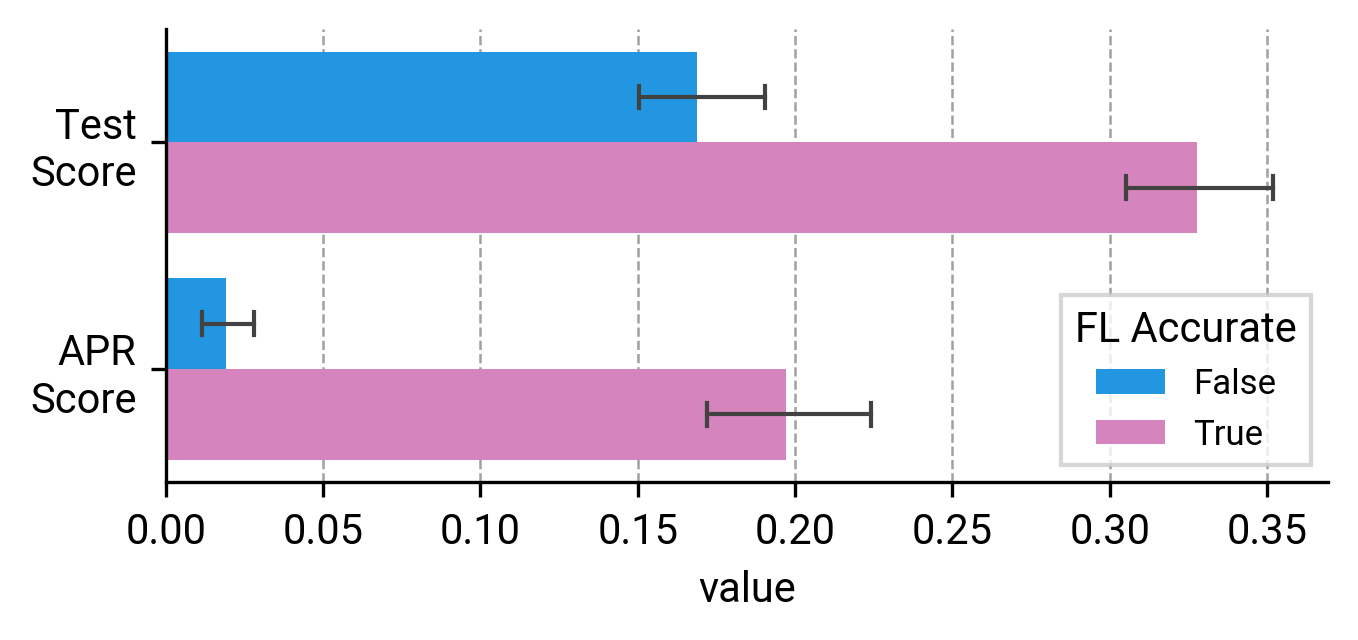

In [14]:
D4J_df = create_FL_dataframe("../combined_fl_results/d4j_gpt3_results_R5_full.json")

patch_df = pd.read_csv("./resources/APR_results.csv")
num_partial_fix = patch_df.groupby(["bug_name", "run_idx"]).is_positive_patch.sum()
partial_fix_booster = (num_partial_fix / 5 + 1).to_dict()

D4J_df_partial_fix = create_FL_dataframe("../combined_fl_results/d4j_gpt3_results_R5_full.json", 
                                        score_booster=partial_fix_booster)

D4J_partial_fix_corr_df = spearmanr_corr_with_confidence(D4J_df_partial_fix)
display(D4J_partial_fix_corr_df.round(2))

testgen_df = pd.read_csv("./resources/TestGen_results.csv")
test_score = testgen_df.groupby(["bug_name", "run_idx"]).success.sum()
test_score_booster = (test_score / 10 + 1).to_dict()

D4J_df_test_score = create_FL_dataframe("../combined_fl_results/d4j_gpt3_results_R5_full.json", 
                                        score_booster=test_score_booster)

D4J_test_score_corr_df = spearmanr_corr_with_confidence(D4J_df_test_score)
display(D4J_test_score_corr_df.round(2))

draw_PR_curve({
    "Original Confidence": D4J_df,
    "Test Score-Boosted Confidence": D4J_df_test_score,
    "APR Score-Boosted Confidence ": D4J_df_partial_fix,
}, showF1=False, savepath="./figures/FutureDirection_confidence_boosted_all.pdf", figsize=(5,2), title=None)


fl_and_APR_score = (
    patch_df.groupby(["bug_name", "run_idx", "fl_worked"]).is_positive_patch.sum()/5
).to_frame().reset_index()
test_score = (testgen_df.groupby(["bug_name", "run_idx"])["success"].sum()/10)
fl_and_aux_score = fl_and_APR_score.join(test_score, on=["bug_name", "run_idx"])
fl_and_aux_score.rename(columns={"is_positive_patch": "APR Score", "success": "Test Score"},
                        inplace=True)
melted = fl_and_aux_score.melt(id_vars=["bug_name", "run_idx", "fl_worked"])
melted = melted.sort_values(by="variable", ascending=False)
melted.rename(columns={"fl_worked": "FL Accurate"}, inplace=True)
plt.figure(figsize=(5, 2))
# plt.title("Distribution of Test and APR Scores")
sns.barplot(data=melted, hue="FL Accurate", x="value", y="variable", orient="h", capsize=.1, errwidth=1)
plt.rc('axes', axisbelow=True)
plt.yticks([0, 1], ["Test\nScore", "APR\nScore"])
plt.ylabel("")
plt.savefig("./figures/FutureDirection_Test_APR_score_distribution.pdf", bbox_inches="tight")